# Use `exoplanet` to fit a `batman` system

In [7]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import batman

from astropy.time import Time

%config InlineBackend.figure_format = "retina"

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [37]:
import astropy.units as u
import astropy.constants as const

In [121]:
n = 3
planet_params = [None for i in range(n)]

for i in range(n):
    params = batman.TransitParams()
    params.t0 = i + 1                       #time of inferior conjunction
    params.per = np.random.uniform(1, 10)                      #orbital period
    params.rp = 10**(np.random.uniform(-2, -1))                      #planet radius (in units of stellar radii)
    params.inc = 90.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.a = np.power((params.per * u.day)**2 * const.G * u.Msun / (4 * np.pi**2), 1/3).to(u.Rsun).value
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    planet_params[i] = params
    
    print(params.per, params.a, params.rp)

3.758401651028535 10.172786210553818 0.06473385823242037
9.320948065401689 18.63850964866435 0.04269367335225027
2.024782394378798 6.735296124391466 0.04290613423750322


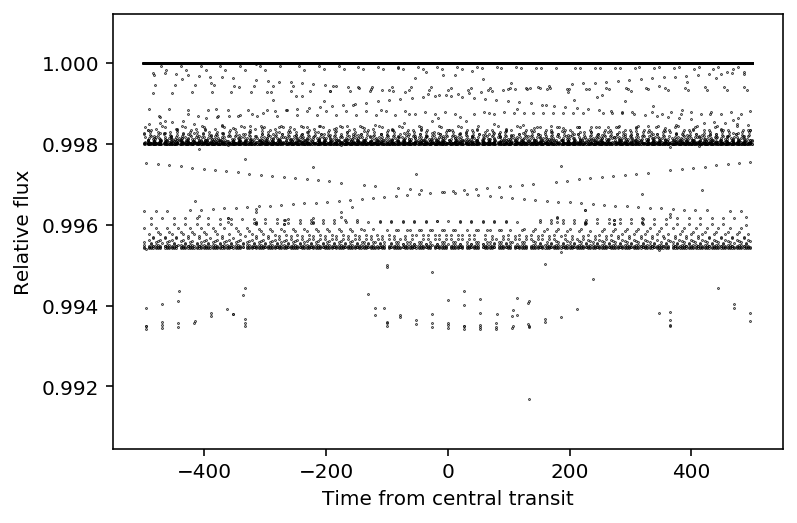

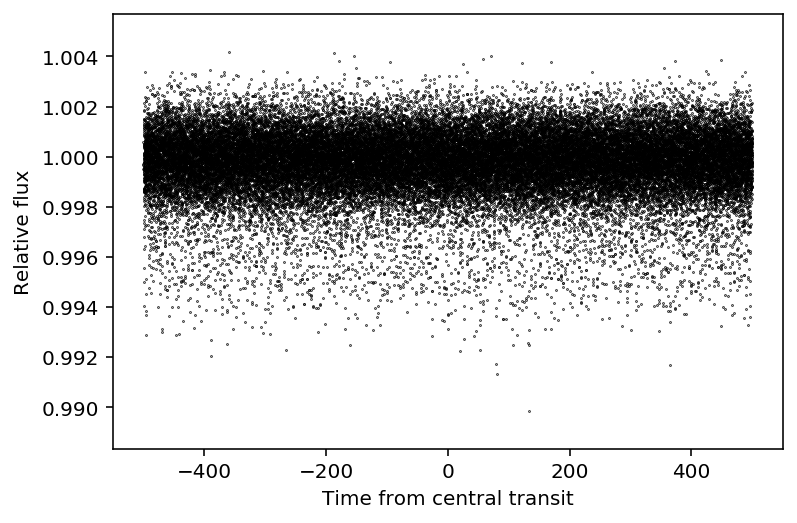

In [147]:
t = np.linspace(-500, 500, 48000)
fluxes = [batman.TransitModel(params, t).light_curve(params) for params in planet_params]

total_flux = np.sum(fluxes, axis=0) - (n - 1)
noise = 0.001
noisy_lc = total_flux + np.random.normal(loc=0, scale=noise, size=len(total_flux))

plt.scatter(t, total_flux, s=0.1, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

plt.scatter(t, noisy_lc, s=0.1, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

# Now to fit things

In [171]:
import pymc3 as pm
import pymc3_ext as pmx

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=[p.t0 for p in planet_params], sd=1.0, shape=len(planet_params))

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log([p.per for p in planet_params]), sd=0.1, shape=len(planet_params))
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening parameters
    limb_dark = xo.distributions.QuadLimbDark("u")

    r = pm.Uniform(
        "r", lower=0.001, upper=0.1, shape=len(planet_params), testval=[p.rp for p in planet_params]#np.ones_like(planet_params) * 0.01
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=len(planet_params), testval=np.random.rand(len(planet_params))
    )

    # fix stellar density across the stars
    log_rho_star = pm.Normal("log_rho_star",
                             mu=np.log10(1.4), sd=1)
    rho_star = pm.Deterministic("rho_star", 10**(log_rho_star))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, rho_star=rho_star)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(limb_dark[0], limb_dark[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting purposes
    pm.Deterministic("light_curves", light_curves)

    y = noisy_lc

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=noise, observed=y)

    # Fit for the maximum a posteriori parameters given the simulated dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 261735.3876366337 -> 263280.49185074144


In [172]:
map_soln

{'mean': array(1.00000503),
 't0': array([1.00009565, 2.00109175, 2.99980109]),
 'logP': array([1.32399393, 2.23226377, 0.70546212]),
 'u_quadlimbdark__': array([-1.36872058, -2.5823004 ]),
 'r_interval__': array([ 0.5953229 , -0.28562381, -0.30614664]),
 'b_impact__': array([-0.93608339, -0.78061812, -0.81575437]),
 'log_rho_star': array(0.08181776),
 'period': array([3.75840225, 9.32094271, 2.02478215]),
 'u': array([0.06330863, 0.38705415]),
 'r': array([0.06481397, 0.04347848, 0.0429815 ]),
 'b': array([0.29994975, 0.32784704, 0.31984658]),
 'rho_star': array(1.20730712),
 'light_curves': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])}

In [167]:
0.06473914 / np.exp(0.59202544)

0.03581405895313184

In [168]:
0.04340076 / np.exp(-0.28882928)

0.05793410433325716

In [164]:
np.exp(-3.18623317)

0.04132725083878713

# Check how well it matches

Text(0.5, 0, 'Time')

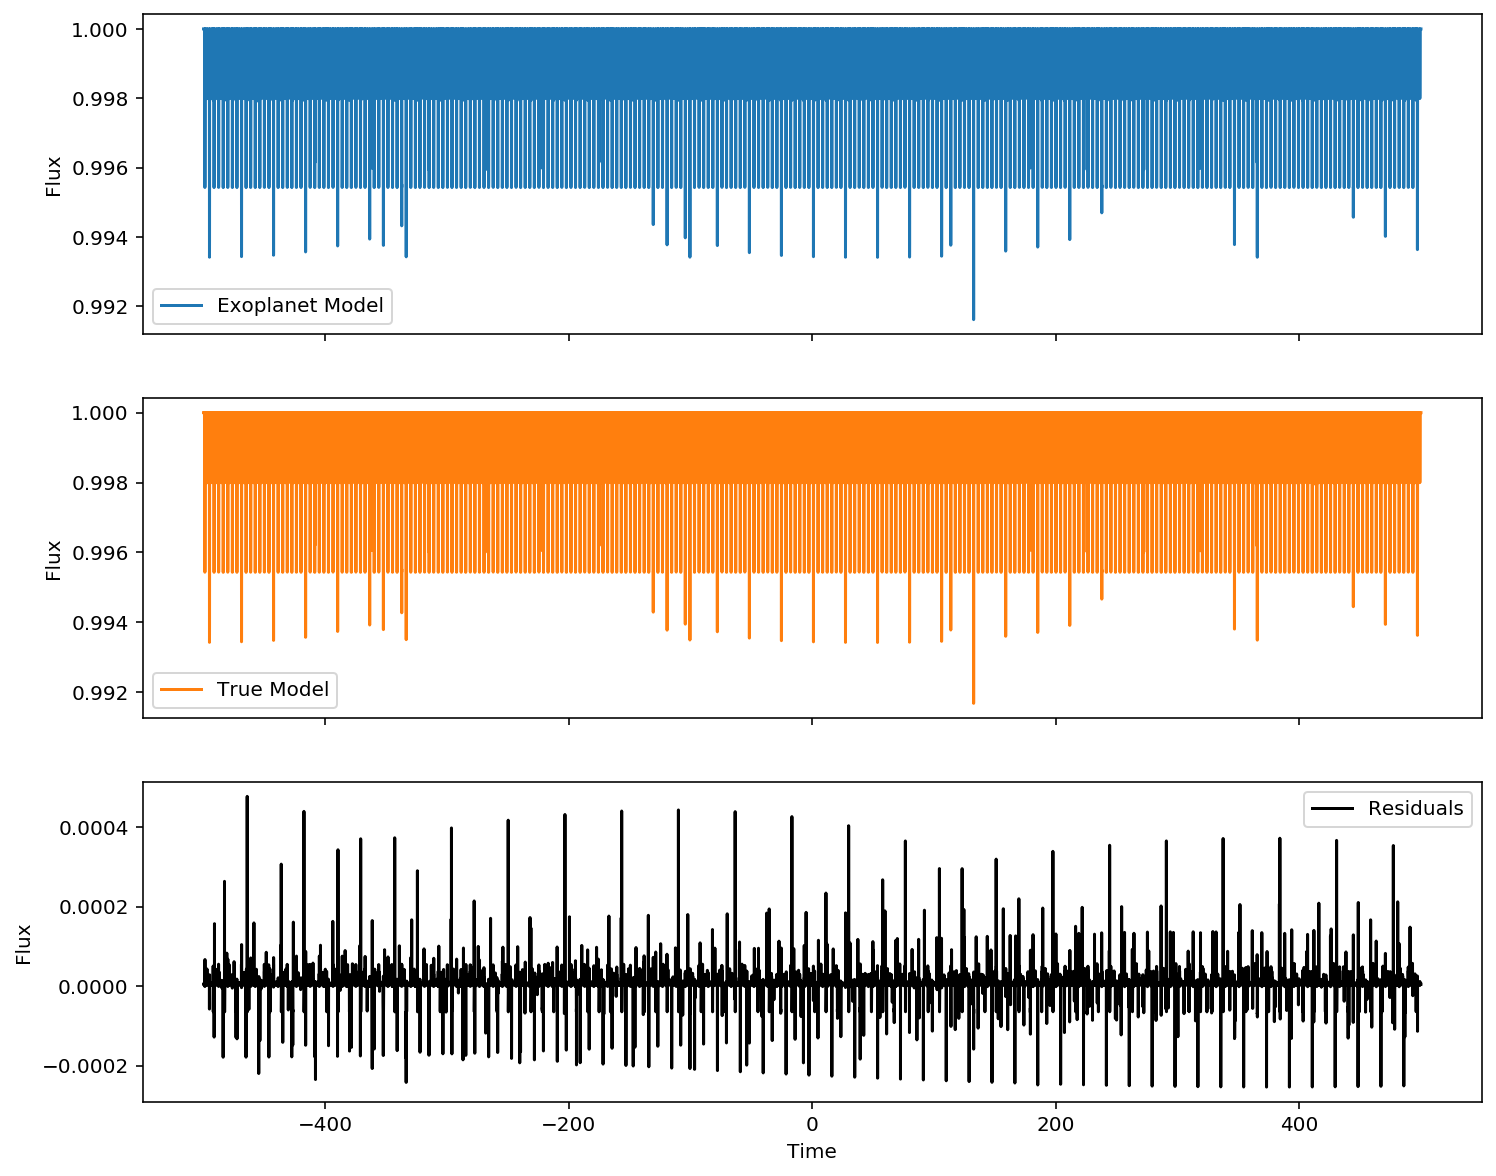

In [173]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(t, np.sum(map_soln["light_curves"], axis=1) + map_soln["mean"], label="Exoplanet Model")
axes[1].plot(t, total_flux, color="tab:orange", label="True Model")
axes[2].plot(t, np.sum(map_soln["light_curves"], axis=1) + map_soln["mean"] - total_flux, c='k', label="Residuals")

for ax in axes:
    ax.legend()
    ax.set_ylabel("Flux")

axes[-1].set_xlabel("Time")

### Parameter comparisons

Period: Good!

In [174]:
print([p.per for p in planet_params])
print(map_soln["period"])

[3.758401651028535, 9.320948065401689, 2.024782394378798]
[3.75840225 9.32094271 2.02478215]


In [175]:
print([p.t0 for p in planet_params])
print(map_soln["t0"])

[1, 2, 3]
[1.00009565 2.00109175 2.99980109]


Radius: Good?

In [176]:
print([p.rp for p in planet_params])
print(map_soln["r"])

[0.06473385823242037, 0.04269367335225027, 0.04290613423750322]
[0.06481397 0.04347848 0.0429815 ]


Limb darkening: Bad!

In [177]:
print([p.u for p in planet_params])
print(map_soln["u"])

[[0.1, 0.3], [0.1, 0.3], [0.1, 0.3]]
[0.06330863 0.38705415]
